# 번역기 익스 


https://www.manythings.org/anki/ 에서 fra-eng.zip을 다운 받아서 사용한다 




In [294]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

In [295]:
import os
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 197463


,eng,fra,cc
98198,The zoo is closed on Monday.,Le zoo est fermé le lundi.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
73564,Maybe that's a good idea.,Peut-être est-ce une bonne idée.,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
74319,That isn't what it means.,Ce n'est pas ce que ça signifie.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
150948,I was a volunteer for two afternoons.,J'ai été bénévole pendant deux après-midis.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
181093,It took me a long time to get used to the noise.,M'accoutumer au bruit me prit un long moment.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [296]:
# 19만에서 5만으로 줄이기 
lines = lines[['eng', 'fra']][:50000] # 5만개 샘플 사용
lines.shape

(50000, 2)

In [297]:
# 시작 토큰과 종료 토큰 추가

sos_token = '\t' # 시작 토큰 sos 

eos_token = '\n' # 종료 토큰 eos 

lines.fra = lines.fra.apply(lambda x : '\t '+ x + ' \n')
print('전체 샘플의 수 :',len(lines))
lines.sample(5)

전체 샘플의 수 : 50000


,eng,fra
35029,Go easy on the wine.,\t Vas-y doucement avec le vin. \n
7021,He lied to me.,\t Il me mentit. \n
23894,I got off lightly.,\t Je m'en suis tiré à bon compte. \n
42661,I know Tom is chubby.,\t Je sais que Tom est grassouillet. \n
35395,He's about to leave.,\t Il est sur le point de sortir. \n


## Tokenizer 

공식 사이트


https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer


사전에 있는 단어의 순서에 맞게 단어를 turning하면서 벡터화 한다  
text를 index로 대응시켜준다 tf idf 나 word count를 기반으로 계산한다 


**num words**  : 단어 빈도 많은 순서로 num_words개의 단어를 보존한다   
**filters** : 걸러낼 문자 리스트를 적어준다   
**char_level** : True하면 모든 문자가 토큰화 된다   
**lower** : 입력받은 문자열을 소문자로 변환할지를 T/F로 적어준다   
**split** : 문자열을 적어줘야하고 단어 분리하는 기준   
**oov_token** : 값이 지정된 경우 text to sequnecne호출과정에서 word_index에 추가되어 out of vocabulary words를 대체한다   


<br>
</br>
<br>
</br>
### Tokeizer method 

1. fit_on_text : 문자 데이터 입력 받아서 리스트 형태로 변환한다   
2. word_index :  단어와 숫자의 key value 쌍을 포함하는 딕셔너리를 반환한다 이때 반환시 자동으로 소문자 변환 되어 들어간다 그리고 느낌표나 구두점은 자동으로 제거 된다   
3. text_to_sequences() : 텍스트안의 단어들을 숫자의 시퀀스의 형태로 변환 (딕셔너리로 변환했으니까 해당 단어들을 다시 정수인코딩하는것)  


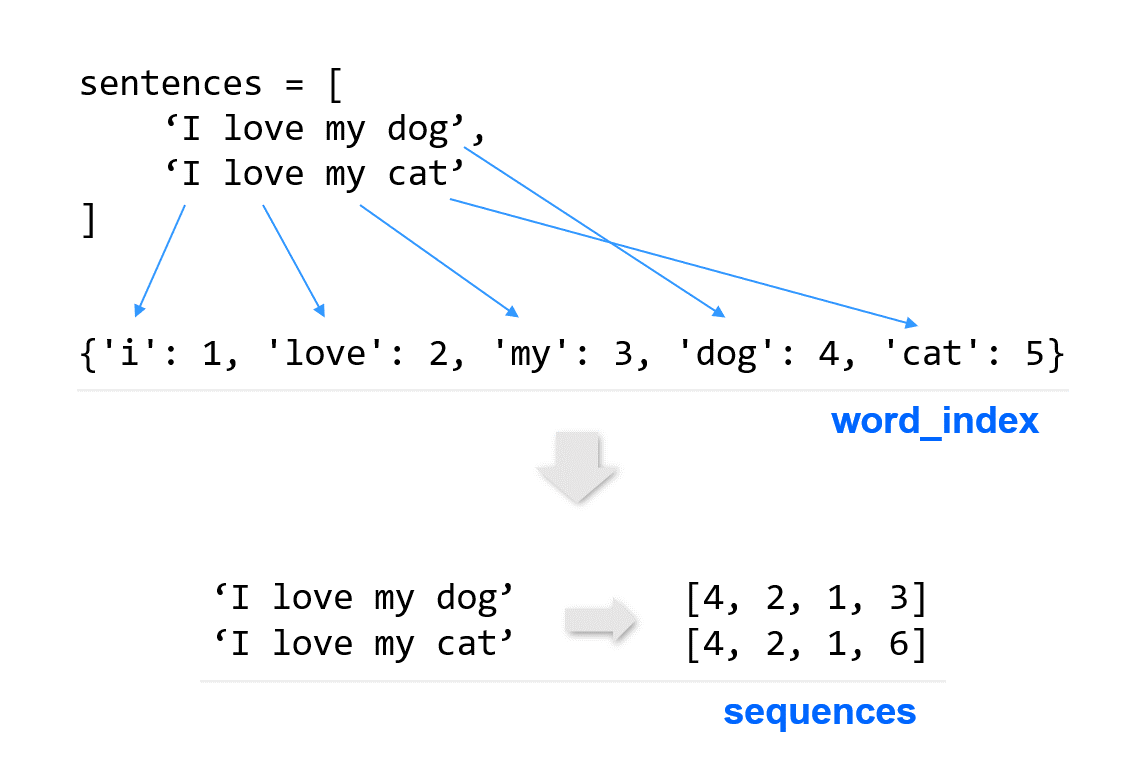  


4. pad_sequences() : 같은 길이를 가지도록 padding하는것이다 가장 긴 길이를 기준으로 하는것 같음  물론 maxlen을 따로 주어도 된다 


문장의 단어를 딕셔너리로 바꿔 토큰화 시킨다 key기준으로 text를 숫자로 이루어진 numpy array로 바꾼다 
<br>
</br>
<br>
</br>




### oov_token

 토큰화 되지 않은것들 처리 한다 OOV로 처리 대체 한다 out of token이라는 의미이다 
 
 


In [298]:
# 영단어 딕셔너리로 바꿔준다 
eng_tokenizer = Tokenizer(char_level=True)   # 문자 단위로 Tokenizer를 생성합니다. 
eng_tokenizer.fit_on_texts(lines.eng)               # 50000개의 행을 가진 eng의 각 행에 토큰화를 수행
input_text = eng_tokenizer.texts_to_sequences(lines.eng)    # 단어를 숫자값 인덱스로 변환하여 저장
input_text[:3]

[[19, 3, 8], [19, 3, 8], [19, 3, 8]]

In [299]:
# 프랑스 단어 딕셔너리 바꾼 값 다시 정수로 
fra_tokenizer = Tokenizer(char_level=True)   # 문자 단위로 Tokenizer를 생성합니다. 
fra_tokenizer.fit_on_texts(lines.fra)                 # 50000개의 행을 가진 fra의 각 행에 토큰화를 수행
target_text = fra_tokenizer.texts_to_sequences(lines.fra)     # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:3]

[[10, 1, 19, 5, 1, 31, 1, 11],
 [10, 1, 15, 5, 12, 16, 29, 2, 14, 1, 11],
 [10, 1, 2, 7, 1, 12, 9, 8, 4, 2, 1, 31, 1, 11]]

In [300]:
# 영어 프랑스 단어장 크기 
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 53
프랑스어 단어장의 크기 : 73


In [301]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 22
프랑스어 시퀀스의 최대 길이 76


In [302]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 50000
영어 단어장의 크기 : 53
프랑스어 단어장의 크기 : 73
영어 시퀀스의 최대 길이 22
프랑스어 시퀀스의 최대 길이 76


 teaching forcing을 위해 디코더에는 두가지 입력이 필요하다
 
 하나는 디코더 입력  ~~~ EOS  
 
 또 하나는 디코더 출력 SOS ~~~~  

In [303]:
encoder_input = input_text

# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text] 


# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]

In [304]:
print(decoder_input[:3])
print(decoder_target[:3])

[[10, 1, 19, 5, 1, 31, 1], [10, 1, 15, 5, 12, 16, 29, 2, 14, 1], [10, 1, 2, 7, 1, 12, 9, 8, 4, 2, 1, 31, 1]]
[[1, 19, 5, 1, 31, 1, 11], [1, 15, 5, 12, 16, 29, 2, 14, 1, 11], [1, 2, 7, 1, 12, 9, 8, 4, 2, 1, 31, 1, 11]]


In [305]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (50000, 22)
프랑스어 입력데이터의 크기(shape) : (50000, 76)
프랑스어 출력데이터의 크기(shape) : (50000, 76)


In [306]:
print(encoder_input[0])

[19  3  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


### 각 정수에 대해서 one hot encoding 하기 

(샘플의 수 * 샘플의 길이 * 단어장의 크기)

In [307]:
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (50000, 22, 53)
프랑스어 입력데이터의 크기(shape) : (50000, 76, 73)
프랑스어 출력데이터의 크기(shape) : (50000, 76, 73)


### train , validation split 

In [308]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 학습데이터의 크기(shape) : (50000, 22, 53)
프랑스어 학습 입력데이터의 크기(shape) : (50000, 76, 73)
프랑스어 학습 출력데이터의 크기(shape) : (50000, 76, 73)


## 모델 훈련 하기 



In [309]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

In [310]:
# Encoder 설계하기 LSTM hidden, cell state 반환 

# 입력 텐서 생성.
encoder_inputs = Input(shape=(None, eng_vocab_size))

# hidden size가 256인 인코더의 LSTM 셀 생성
encoder_lstm = LSTM(units = 256, return_state = True)

# 디코더로 전달할 hidden state, cell state를 리턴. encoder_outputs은 여기서는 불필요.
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# hidden state와 cell state를 다음 time step으로 전달하기 위해서 별도 저장.
encoder_states = [state_h, state_c]

In [311]:
# decoder 설계 
# 입력 텐서 생성.
decoder_inputs = Input(shape=(None, fra_vocab_size))

# hidden size가 256인 인코더의 LSTM 셀 생성
decoder_lstm = LSTM(units = 256, return_sequences = True, return_state=True)

# decoder_outputs는 모든 time step의 hidden state
decoder_outputs, _, _= decoder_lstm(decoder_inputs, initial_state = encoder_states)

In [312]:
# Decoder 출력 층 

decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [313]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")
model.summary()

Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           [(None, None, 53)]   0                                            
__________________________________________________________________________________________________
input_38 (InputLayer)           [(None, None, 73)]   0                                            
__________________________________________________________________________________________________
lstm_13 (LSTM)                  [(None, 256), (None, 317440      input_37[0][0]                   
__________________________________________________________________________________________________
lstm_14 (LSTM)                  [(None, None, 256),  337920      input_38[0][0]                   
                                                                 lstm_13[0][1]             

In [315]:
model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train,
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=30)

Epoch 1/30
368/368 [==============================] - 7s 19ms/step - loss: 0.2214 - val_loss: 0.3580
Epoch 2/30
368/368 [==============================] - 7s 19ms/step - loss: 0.2164 - val_loss: 0.3593
Epoch 3/30
368/368 [==============================] - 7s 19ms/step - loss: 0.2120 - val_loss: 0.3546
Epoch 4/30
368/368 [==============================] - 7s 19ms/step - loss: 0.2078 - val_loss: 0.3591
Epoch 5/30
368/368 [==============================] - 7s 19ms/step - loss: 0.2039 - val_loss: 0.3544
Epoch 6/30
368/368 [==============================] - 7s 19ms/step - loss: 0.2001 - val_loss: 0.3565
Epoch 7/30
368/368 [==============================] - 7s 19ms/step - loss: 0.1967 - val_loss: 0.3589
Epoch 8/30
368/368 [==============================] - 7s 19ms/step - loss: 0.1932 - val_loss: 0.3594
Epoch 9/30
368/368 [==============================] - 7s 19ms/step - loss: 0.1901 - val_loss: 0.3606
Epoch 10/30
368/368 [==============================] - 7s 19ms/step - loss: 0.1870 - val_lo

## 모델 평가 

테스트 단계와 훈련할때 다르니까 디코더 모델 설계 다시 해줄 필요 있다   

왜??  
train 사용할때는 학습해야할 타켓 문장을 디코더 모델의 입력 출력 시퀀스로 넣어주고 디코더 모델이 타켓  문장을 한꺼번에 출력하게 할수있다

test에서는 그럴수가 없다 하나의 문장을 만들어 내기 위해 루프를 돌며 단어를 하나씩 차례차례 예측하면서 예측된 단어가 다음 입력으로 재사용되는 과정이 반복되기 때문이다 

1. 인코더에 입력 문장을 넣어 마지막 time step의 hidden, cell state를 얻는다.
2. sos 토큰인 '\t'를 디코더에 입력한다.
3. 이전 time step의 출력층의 예측 결과를 현재 time step의 입력으로 한다.
4. 3을 반복하다가 eos 토큰인 '\n'이 예측되면 이를 중단한다.

<br>
</br>

이전 time step의 출력층의 예측 결과를 현재 time step의 입력으로 사용하는 단계를 추가해야 한다는 것입니다. 그렇기 때문에 루프를 돌며 디코더의 LSTM 셀을 수동 제어하는 느낌으로 설계해야 합니다. 코드가 좀 더 길어지게 되는데요.

In [316]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, None, 53)]        0         
_________________________________________________________________
lstm_13 (LSTM)               [(None, 256), (None, 256) 317440    
Total params: 317,440
Trainable params: 317,440
Non-trainable params: 0
_________________________________________________________________


In [317]:
# 이전 time step의 hidden state를 저장하는 텐서
decoder_state_input_h = Input(shape=(256,))

# 이전 time step의 cell state를 저장하는 텐서
decoder_state_input_c = Input(shape=(256,))

# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# decoder_states_inputs를 현재 time step의 초기 상태로 사용.
# 구체적인 동작 자체는 def decode_sequence()에 구현.
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state = decoder_states_inputs)

# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장.
decoder_states = [state_h, state_c]

In [318]:
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)
decoder_model.summary()

Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           [(None, None, 73)]   0                                            
__________________________________________________________________________________________________
input_39 (InputLayer)           [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_40 (InputLayer)           [(None, 256)]        0                                            
__________________________________________________________________________________________________
lstm_14 (LSTM)                  [(None, None, 256),  337920      input_38[0][0]                   
                                                                 input_39[0][0]            

In [319]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [320]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1, fra_vocab_size))
    target_seq[0, 0, fra2idx['\t']] = 1.

    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1, fra_vocab_size))
        target_seq[0, 0, sampled_token_index] = 1.

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [321]:
import numpy as np
for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.eng[seq_index])
    print('정답 문장:', lines.fra[seq_index][1:len(lines.fra[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) # '\n'을 빼고 출력

-----------------------------------
입력 문장: Go.
정답 문장:  Bouge ! 
번역기가 번역한 문장:  bouge ! 
-----------------------------------
입력 문장: Hello!
정답 문장:  Bonjour ! 
번역기가 번역한 문장:  à l'aute ! 
-----------------------------------
입력 문장: Got it?
정답 문장:  T'as capté ? 
번역기가 번역한 문장:  vite ? 
-----------------------------------
입력 문장: Hang on.
정답 문장:  Tiens bon ! 
번역기가 번역한 문장:  tiens bon ! 
-----------------------------------
입력 문장: Here's $5.
정답 문장:  Voilà cinq dollars. 
번역기가 번역한 문장:  nous voilons. 


# 번역기 단어 레벨로 업그레이드 하기 


- 익스 시작 

In [322]:
import tensorflow

print(tensorflow.__version__)

2.6.0


<br>
</br>  


**step1+2** : 상위 3만 3천개 사용하고 train 3만 test 3천으로 하기 그리고 embedding layer 사용하기 

<br>
</br>

1. 구두점을 단어와 분리 하는 전처리 하기
2. 소문자로 바궈주기 
3. 입력시퀀스와 레이블 시퀀스 구성하기  


In [323]:

import numpy as np
import pandas as pd
import tensorflow as tf
import unicodedata
import re 
import os
from tensorflow.keras.layers import Embedding, GRU, Dense,LSTM,Input,Masking
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [324]:
# 데이터 불러오기 

file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력


전체 샘플의 수 : 197463


,eng,fra,cc
53900,Where are you working?,Où travailles-tu ?,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
23647,I arrived on time.,Je suis arrivé à l'heure.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
60509,Watch out for that man.,Gare à cet homme-là.,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
66810,The key is on the table.,La clé est sur la table.,CC-BY 2.0 (France) Attribution: tatoeba.org #7...
23305,He has a headache.,Il a un mal de tête.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...


In [325]:
#33000 개 샘플로 사용 
lines = lines[['eng', 'fra']][:33000]
lines.shape

(33000, 2)

In [326]:
# 유니코드를 아스키 코드로 변환 하는 함수 

def to_ascii(string):
    return "".join(asc for asc in unicodedata.normalize("NFD",string)
                         if unicodedata.category(asc)!="Mn")



In [327]:
def preprocess_sentence(sent):
    sent = to_ascii(sent.lower()) # 소문자 변환 후 공백 제거  
    
    """
   재참조 메타 문자인 \1이다. \1은 정규식의 그룹 중 첫 번째 그룹을 가리킨다.
    
    """
    
    sent = re.sub(r"([?.!,¿])", r" \1", sent) # 단어와 구두점 사이의 공백 추가 
    
    sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent) # 유효한거 빼고 다 공백 
    
    sent = re.sub(r"\s+", " ", sent) # 다수의 공백을 하나의 공백으로 치환 한다 
    return sent 




In [328]:
# 잘 출력되는지 확인해 보기 

#유니 코드가 아스키로 변환해야하는거니까 유니코드 문장을 사용했다 
english = u"I am fine$$%% thank you$$$$and$$$you?"
frangs = u"Je vais bien merci à vous et à vous."

print('전처리 전 영어 문장 :', english)
print('전처리 후 영어 문장 :',preprocess_sentence(english))
print('전처리 전 프랑스어 문장 :', frangs)
print('전처리 후 프랑스어 문장 :', preprocess_sentence(frangs))


전처리 전 영어 문장 : I am fine$$%% thank you$$$$and$$$you?
전처리 후 영어 문장 : i am fine thank you and you ?
전처리 전 프랑스어 문장 : Je vais bien merci à vous et à vous.
전처리 후 프랑스어 문장 : je vais bien merci a vous et a vous .


In [329]:
# SOS EOS 토큰 넣기 

def load_sentence_data():
    encoder_input,teaching_force,decoder_target = [],[],[]
    
    # 영어 데이터 전처리 적용하기 
    for src in lines["eng"]:
        
        src  = [w for w in preprocess_sentence(src).split()] # 공백기준으로 나누기
        
        # encoder input에 추가하기 
        encoder_input.append(src)
    
    
    
    # 프랑스 데이터 전처리 적용하기
    for tar in lines["fra"]:
        
        tar = preprocess_sentence(tar) # france 전처리 하기 
        
        #전처리 한 프랑스어 토큰 붙히기 
        tar_in = [w for w in ("<SOS>"+tar).split()]
        tar_out = [w for w in (tar+"<EOS>").split()]
        
        teaching_force.append(tar_in)
        decoder_target.append(tar_out)
    
        
    return encoder_input,teaching_force,decoder_target


        
    
        

In [330]:
# 잘 되는지 확인해보기 
sents_en_in, sents_teaching_force, sents_fra_out = load_sentence_data()
print('인코더의 입력 :',sents_en_in[:5])
print('디코더의 입력 :',sents_teaching_force[:5])
print('디코더의 레이블 :',sents_fra_out[:5])


인코더의 입력 : [['go', '.'], ['go', '.'], ['go', '.'], ['go', '.'], ['hi', '.']]
디코더의 입력 : [['<SOS>va', '!'], ['<SOS>marche', '.'], ['<SOS>en', 'route', '!'], ['<SOS>bouge', '!'], ['<SOS>salut', '!']]
디코더의 레이블 : [['va', '!<EOS>'], ['marche', '.<EOS>'], ['en', 'route', '!<EOS>'], ['bouge', '!<EOS>'], ['salut', '!<EOS>']]


Decoder encoder와 마찬가지로 여러개의 RNN으로 되어있다 설계시 인코딩에서 나온 context vector를 초기 은닉층으로 사용하고 처음 셀에서 단어를 예측한 결과를 다시 입력으로 사용하면서 진행하는데 디코더의 입력을 teaching force로 고정 시켜야 잘못 진행되는거을 예방 할수있다 


# Tokenizer 하기 

이미 전처리 했으니까 tokenizer에서 디폴트로 설정되어있는 filter를 ""로 설정하고 
이미 소문자 바꿨으니까 lower도 False로 진행한다 



In [331]:
# 영어 tokenizer
tokenizer_en = Tokenizer(filters="", lower=False)
tokenizer_en.fit_on_texts(sents_en_in)
encoder_input = tokenizer_en.texts_to_sequences(sents_en_in) # 정수 인코딩 결과 

# 프랑스 tokenizer
tokenizer_fra = Tokenizer(filters="", lower=False)
tokenizer_fra.fit_on_texts(sents_teaching_force)
tokenizer_fra.fit_on_texts(sents_fra_out)

decoder_input = tokenizer_fra.texts_to_sequences(sents_teaching_force)
decoder_target = tokenizer_fra.texts_to_sequences(sents_fra_out)



In [332]:
src_vocab_size = len(tokenizer_en.word_index) + 1
tar_vocab_size = len(tokenizer_fra.word_index) + 1
print("영어 단어 집합의 크기 : {:d}, 프랑스어 단어 집합의 크기 : {:d}".format(src_vocab_size, tar_vocab_size))

영어 단어 집합의 크기 : 4672, 프랑스어 단어 집합의 크기 : 9307


In [333]:
# 최대 길이 구하기 

max_eng_seq_len = max([len(line) for line in encoder_input])
max_fra_seq_len = max([len(line) for line in decoder_target])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 15


In [334]:
print('전체 샘플의 수 :',len(lines))
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 15


In [335]:
#Padding 

encoder_input = pad_sequences(encoder_input, maxlen=max_eng_seq_len,padding="pre")
decoder_input = pad_sequences(decoder_input,maxlen=max_fra_seq_len, padding="pre")
decoder_target = pad_sequences(decoder_target, maxlen=max_fra_seq_len,padding="pre")

In [336]:
print('인코더의 입력의 크기(shape) :',encoder_input.shape)
print('디코더의 입력의 크기(shape) :',decoder_input.shape)
print('디코더의 레이블의 크기(shape) :',decoder_target.shape)

인코더의 입력의 크기(shape) : (33000, 8)
디코더의 입력의 크기(shape) : (33000, 15)
디코더의 레이블의 크기(shape) : (33000, 15)


# train , test 나누기 

In [337]:
encoder_input_train = encoder_input[:30000]
decoder_input_train = decoder_input[:30000]
decoder_target_train = decoder_target[:30000]

encoder_input_test = encoder_input[30000:]
decoder_input_test = decoder_input[30000:]
decoder_target_test = decoder_target[30000:]


In [338]:
print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_target_train.shape)
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_target_test.shape)

훈련 source 데이터의 크기 : (30000, 8)
훈련 target 데이터의 크기 : (30000, 15)
훈련 target 레이블의 크기 : (30000, 15)
테스트 source 데이터의 크기 : (3000, 8)
테스트 target 데이터의 크기 : (3000, 15)
테스트 target 레이블의 크기 : (3000, 15)


# 모델 만들기 


In [339]:
embedding_dim = 128
hidden_units = 128

In [340]:
# Encoder 만들기 

encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(src_vocab_size, embedding_dim)(encoder_inputs)
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(hidden_units, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking) 
encoder_states = [state_h, state_c] # context vector 


In [341]:
 # Decoder 초기 은닉 상태 ==인코더의 마지막 은닉 상태 

decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab_size, hidden_units) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # decoder의 입력 
dec_masking = Masking(mask_value=0.0)(dec_emb) 


# return sequnces return state 모두 True이다 
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True) 

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_outputs, _, _ = decoder_lstm(dec_masking,
                                     initial_state=encoder_states)  #context vector입력 받음 


# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
 



one hot encoding이 아니므로 catetgorical 쓰지 않고 sparse_categorical_CE를 사용한다 

그리고 model fit 할때 validation_split을 0.2로 주어서 따로  validation을 사용했다 


In [342]:
# 모델의 입력과 출력을 정의.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [343]:
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train,
          validation_split =0.2,batch_size=128, epochs=30)


Epoch 1/30
188/188 [==============================] - 14s 42ms/step - loss: 3.2163 - acc: 0.6693 - val_loss: 2.6618 - val_acc: 0.6216
Epoch 2/30
188/188 [==============================] - 6s 31ms/step - loss: 1.8983 - acc: 0.6865 - val_loss: 1.9764 - val_acc: 0.6878
Epoch 3/30
188/188 [==============================] - 6s 31ms/step - loss: 1.4791 - acc: 0.7533 - val_loss: 1.6199 - val_acc: 0.7394
Epoch 4/30
188/188 [==============================] - 6s 31ms/step - loss: 1.1782 - acc: 0.8218 - val_loss: 1.3085 - val_acc: 0.8192
Epoch 5/30
188/188 [==============================] - 6s 32ms/step - loss: 0.9563 - acc: 0.8689 - val_loss: 1.1025 - val_acc: 0.8549
Epoch 6/30
188/188 [==============================] - 6s 31ms/step - loss: 0.8172 - acc: 0.8891 - val_loss: 0.9751 - val_acc: 0.8711
Epoch 7/30
188/188 [==============================] - 6s 31ms/step - loss: 0.7244 - acc: 0.9018 - val_loss: 0.8845 - val_acc: 0.8870
Epoch 8/30
188/188 [==============================] - 6s 31ms/step -

In [344]:
import matplotlib.pyplot as plt
# 시각화 하기 
def training_validate_loss_acc(history_dict):
    acc = history_dict['acc']
    val_acc = history_dict['val_acc']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    # "bo"는 "파란색 점"입니다
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b는 "파란 실선"입니다
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [345]:
history_dict = history.history


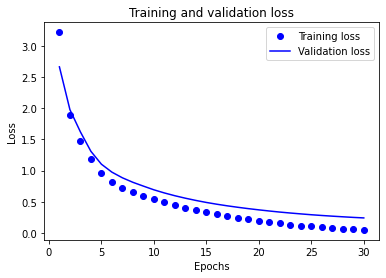

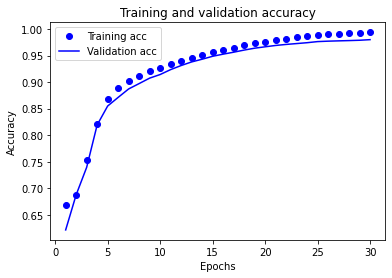

In [346]:
training_validate_loss_acc(history_dict)

In [347]:
# 모델 평가 하기 

results = model.evaluate([encoder_input_test,decoder_input_test] ,decoder_target_test, verbose=2)

print(results)

94/94 - 1s - loss: 0.2705 - acc: 0.9779
[0.27053484320640564, 0.9778888821601868]


# Seq2Seq 구조로 만들기

teaching force를 해야 하기때문에 디코더를 수정해야한다 
1. 번역하고자 하는 입력 문장이 인코더로 입력되어 인코더의 마지막 시점의 은닉 상태와 셀 상태를 얻습니다.  
2. 인코더의 은닉 상태와 셀 상태, 그리고 토큰 sos를 디코더로 보냅니다.  
3. 디코더가 토큰 eos가 나올 때까지 다음 단어를 예측하는 행동을 반복합니다. 




In [348]:
# 인코더
encoder_model = Model(encoder_inputs, encoder_states)

# 디코더 이전시점의 상태 보관 
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2 = dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측
decoder_outputs2 = decoder_dense(decoder_outputs2)

# 수정된 디코더
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)


In [349]:
src_to_index = tokenizer_en.word_index
index_to_src = tokenizer_en.index_word
tar_to_index = tokenizer_fra.word_index
index_to_tar = tokenizer_fra.index_word

In [350]:
index_to_tar[0] = ' '

In [351]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # 에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1)) 
    target_seq[0, 0] = tar_to_index["<SOS>"]
    
    stop_condition = False
    decoded_sentence = ""
 
    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
       
        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
     
     
        sampled_char = index_to_tar[sampled_token_index]
        
        
        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # 에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '<EOS>' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장     
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]
    
    return decoded_sentence

In [352]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
    sentence = ''
    for encoded_word in input_seq:
        if(encoded_word != 0):
            sentence = sentence + index_to_src[encoded_word] + ' '
    return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
    sentence = ''
    for encoded_word in input_seq:
        if(encoded_word != 0 and encoded_word != tar_to_index['<SOS>'] and encoded_word != tar_to_index['<EOS>']):
            sentence = sentence + index_to_tar[encoded_word] + ' '
    return sentence

In [353]:
import numpy as np
for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.eng[seq_index])
    print('정답 문장:', lines.fra[seq_index][1:len(lines.fra[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) # '\n'을 빼고 출력

입력문장 : go . 
정답문장 : <SOS>bouge ! 
번역문장 :           
--------------------------------------------------
입력문장 : hello ! 
정답문장 : <SOS>bonjour ! 
번역문장 :           
--------------------------------------------------
입력문장 : got it ? 
정답문장 : <SOS>t as capte ? 
번역문장 :           
--------------------------------------------------
입력문장 : hang on . 
정답문장 : <SOS>tiens bon ! 
번역문장 :           
--------------------------------------------------
입력문장 : here s . 
정답문장 : <SOS>voila cinq dollars . 
번역문장 :           
--------------------------------------------------


# 회고 



디코더의 원래 구조에서 teaching force로 seq2seq에서는 바뀌는데 아직 어떤 부분에서 teaching force가 적용되는지 명확히는 모르겠다 

그리고 디코더 설계도 아직 잘 모르겠다 거의 참고 한 코드로 작성이 되었고 이해해보려 했지만 한계를 느꼈다 

그리고 번역결과가 잘 안된것 같은데 Attention을 할때는 조금더 개선 되었으면 좋겠다 






참고  https://wikidocs.net/86900
